In [1]:
# <!--------------------------------------------------------------------------->
# <!--                    KU - University of Copenhagen                      -->
# <!--                          Faculty of Science                           -->
# <!--                Vision and Image Processing (VIP) Course               -->
# <!-- File       : main.ipynb                                               -->
# <!-- Description: Feature matching and image stitching                     -->
# <!-- Author     : Wengguang Zheng, Weisi Li                                -->
# <!--------------------------------------------------------------------------->

__version__ = "$Revision: 2020010401 $"


In [2]:
import numpy as np  
import matplotlib.pyplot as plt  
import cv2
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
import random

In [13]:
def get_harris_position(img, blockSize=100, aperture_size=9, k=0.04, threshold=0.01):
    """
    Harris Corner Detection
    :param img: input image
    :param blockSize: Harris detector window/block size
    :param aperture_size: meow
    :param k:meow
    :param thresholdthreshold: meow
    :return corners: x-row-[0], y-col-[1]
    """
    #get harris descriptor
    dst = cv2.cornerHarris(img, blockSize, aperture_size, k)
    dst = cv2.dilate(dst, None)
    ret, dst = cv2.threshold(dst, threshold * dst.max(), 255, 0)
    dst = np.uint8(dst)

    #find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

    #define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(img,np.float32(centroids), (5,5), (-1,-1), criteria)
    
    return corners

def show_corner(img, corners):
    """
    Show detected corners
    :param img: input image
    :param corners: list of corners, x-row-[0], y-col-[1]
    """
    fig, ax = plt.subplots()  # show corners
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(corners[:, 0], corners[:, 1], '.b', markersize=7)
    plt.title('Detected Corners')
    plt.show()

In [4]:
def get_patch(img, corners, n, d):
    """
    Given a list of corners, extract "n" size windows/patchs
    :param img: input image
    :param corner: x-row-[0], y-col-[1]
    :param n: window/patch size
    :param d: range of needs img, (x_min, x_max, y_min, y_max)
    :return patchs, filter_corners
    """
    def extract_patch(corner):
        x = int(corner[0]) 
        y = int(corner[1]) 
        size_n = int(n/2)
        patch = img[(x-size_n):(x+size_n+1), (y-size_n):(y+size_n+1)]
        return patch 

    range_check = lambda x : x[1] > d[0] and x[1] < d[1] and x[0] > d[2] and x[0] < d[3]
    patchs = []
    filter_corners = []
    scaler = StandardScaler() 
     
    for each_corner in corners:
        if not range_check(each_corner): continue
        patch = extract_patch(each_corner)
        
        if len(patch)>0 and patch.shape == (n,n):
            patch = scaler.fit_transform(patch) 
            patchs.append(patch)
            filter_corners.append(each_corner)

    return patchs,filter_corners

In [5]:
def ssd(patch_A, patch_B, corners_A, corners_B, r=0.8, dx=0, dy=0, margin=300):
    """
    SSD similarity detection, from A to B
    :param r: the ratio threshold of similarity
    :param dx,dy: x and y translation
    :param margin: a range of detect tolarance
    :return match_patchs, match_patchs_corners_A, match_patchs_corners_B
    """
    match_patchs = []
    match_patchs_corners_A = []
    match_patchs_corners_B = []
    
    for each_patch_A, each_corner_A in zip(patch_A, corners_A):
        similarity1 = [999,0]
        similarity2 = [999,0]
        
        x1 = each_corner_A[1] + dx - margin
        x2 = each_corner_A[1] + dx + margin
        y1 = each_corner_A[0] + dy - margin
        y2 = each_corner_A[0] + dy + margin

        range_check = lambda x : x[1] > x1 and x[1] < x2 and x[0] > y1 and x[0] < y2
        
        for i, (each_patch_B, each_corner_B) in enumerate(zip(patch_B,corners_B)):
            if not range_check(each_corner_B): continue

            p1_sub_p2 = np.subtract(each_patch_A, each_patch_B)
            p1p2square = np.power(p1_sub_p2, 2)
            score = np.power(np.sum(p1p2square), 0.5)

            if score < similarity1[0]:
                similarity1 = [score,i]
            elif score < similarity2[0]:
                similarity2 = [score,i]

        if similarity1[0] < r * similarity2[0]:
        	match_patchs.append([each_patch_A, patch_B[similarity1[1]]])
        	match_patchs_corners_A.append(each_corner_A)
        	match_patchs_corners_B.append(corners_B[similarity1[1]])
        	
    return match_patchs,match_patchs_corners_A,match_patchs_corners_B

def ssdstat(matches):
    """
    SSD Standard
    """
    totals = []
    for each_array1 in matches:
        total = np.subtract(each_array1[0:1], each_array1[1:2])
        total = np.power(total, 2)
        total = np.power(np.sum(total), 0.5)
        totals.append(total)
    return totals


In [6]:
def eliminateMultiCorrespondence(patchs, corners_2B_A,corners_2B_B,corners_2A_A,corners_2A_B):
    """
    Find out correspondence, corners exist in both AtoB and BtoA.
    :return match_patchs, match_corners_A, match_corners_B
    """
    match_patchs = []
    match_corners_A = []
    match_corners_B = []

    for i, (B_A, B_B) in enumerate(zip(corners_2B_A, corners_2B_B)):
        for A_A, A_B in zip(corners_2A_A, corners_2A_B):
            if B_A.tolist() == A_A.tolist() and B_B.tolist() == A_B.tolist():
                match_corners_A.append(B_A)
                match_corners_B.append(B_B)
                match_patchs.append(patchs[i])

    return match_patchs, match_corners_A, match_corners_B


In [7]:
def to_kpt(pt,size=1):
    """
    Convert potint to cv2 Keypoint format.
    """
    return cv2.KeyPoint(pt[0], pt[1], size)


def stitch_imgs(img1, img2):
    """
    img1 and img2 can be the same
    """
    img = np.concatenate((img1, img2), axis = 1)
    return img 

In [9]:
def draw_lines(image, start_points, end_points, color = (0,255,0), thickness = 5):
    """
    Draw lines.
    """
    img = image.copy()
    width = int(img.shape[1] / 2)
    for start, end in zip(start_points, end_points):
        start = start.astype(int)
        end = end.astype(int)
        cv2.circle(img, (start[0], start[1]), 50, (255,0,0), 7)
        cv2.circle(img, (end[0] + width, end[1]), 50, (255,0,0), 7)
        cv2.line(img, (start[0], start[1]), (end[0] + width, end[1]),color,thickness)
    
    plt.figure(figsize=(15, 7))
    plt.imshow(img,plt.cm.gray)
    plt.show()

    # return img

In [10]:
def constructA(l, r):
    """
    Construct matrix A
    """
    result = []
    for i in range(len(l)):
        xl = l[i][1]
        yl = l[i][0]
        xr = r[i][1]
        yr = r[i][0]
        result.append([-xl, -yl, -1, 0, 0, 0, xl * xr, yl * xr, xr])
        result.append([0, 0, 0, -xl, -yl, -1, xl * yr, yl * yr, yr])
    return np.array(result)

def computeH(A_pts, B_pts):
    """
    Compute Homography matrix
    """
    A = constructA(A_pts, B_pts)
    U, s, V = np.linalg.svd(A)
    H = V[:,-1]
    H = H.reshape(3,3) / H[-1]
    return H

In [11]:
# MAIN
#============== LOAD ================#
img1_origin = cv2.imread('./inputs/im1red.png')
img2_origin = cv2.imread('./inputs/im2red.png')

img1 = cv2.cvtColor(img1_origin, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_origin, cv2.COLOR_BGR2GRAY)

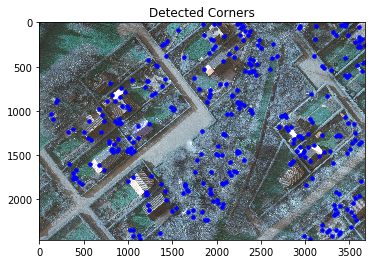

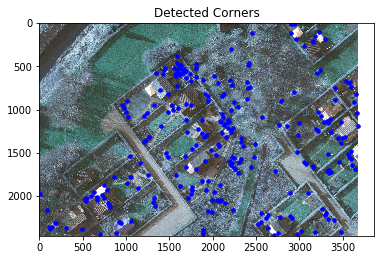

In [14]:
#============== 1.Detecting interest points ==============#
#print(type(img1),img1,np.shape(img1))
corners_A = get_harris_position(img1,blockSize=20,aperture_size=7,k=0.01,threshold = 0.1)
corners_B = get_harris_position(img2,blockSize=20,aperture_size=7,k=0.01,threshold = 0.1)

show_corner(img1_origin,corners_A)
show_corner(img2_origin,corners_B)
#============== 1.Detecting interest points Done ==============#

In [15]:
#============== 2.Feature matching ==============#
replicate_img1 = cv2.copyMakeBorder(img1,30,30,30,30,cv2.BORDER_REPLICATE)
replicate_img2 = cv2.copyMakeBorder(img2,30,30,30,30,cv2.BORDER_REPLICATE)

#----- 2.1 For each extracted point you attribute a descriptor ------#
# Get windows
# Side length
n = 31 #(the patch size, between 3-31, odd)
# Test it one by one! 
print("The patch size",n)

#--- hint3 ---#
dx = 1300
dy = -100
d1=(0, dx, -dy, replicate_img1.shape[1])
patches_A, patches_corners_A = get_patch(replicate_img1, corners_A, n, d1)
d2=(dx, replicate_img2.shape[0], 0, replicate_img2.shape[1]+dy)
patches_B, patches_corners_B = get_patch(replicate_img2, corners_B, n, d2)

n/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversio

In [19]:
#----- 2.2 select matches as the pair of interest points that have most similar descriptors ----#

#(the ratio between best match and the second match)
# for r in [0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6]:
# Test it one by one! 
#--- hint1 ---#
r = 0.99
print("Ratio",r)

patchs_2B, corners_2B_A, corners_2B_B= ssd(patches_A, patches_B, patches_corners_A,patches_corners_B, r, dx, dy)

patchs_2A, corners_2A_B, corners_2A_A= ssd(patches_B, patches_A,  patches_corners_B,patches_corners_A, r, -dx, -dy)

Ratio 0.99


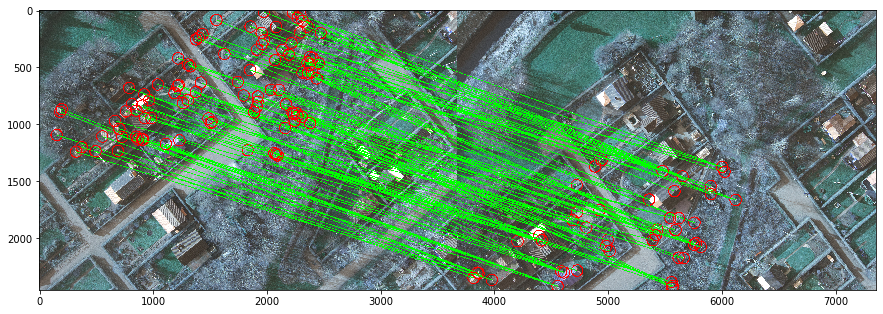

In [17]:
# Show One to More AtoB results(for report)
combined_img = stitch_imgs(img1_origin,img2_origin)
draw_lines(combined_img, corners_2B_A, corners_2B_B)


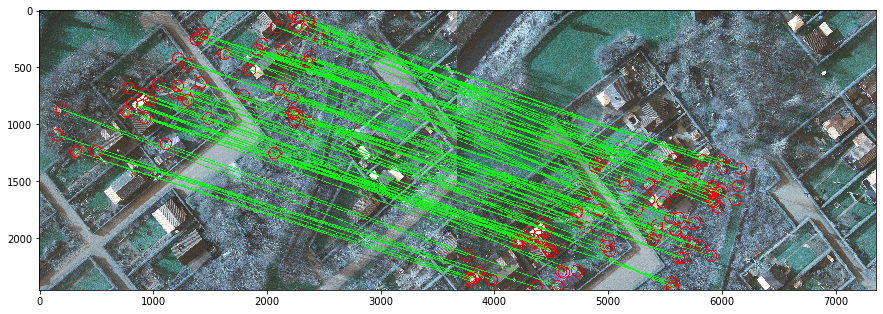

In [20]:
# Show One to More BtoA results(for report)
combined_img = stitch_imgs(img1_origin,img2_origin)
draw_lines(combined_img, corners_2A_A, corners_2A_B)

In [21]:
#--- hint2 ---#
match_patchs, match_corners_A,match_corners_B  = eliminateMultiCorrespondence(patchs_2B, corners_2B_A, corners_2B_B, corners_2A_A, corners_2A_B)

total = ssdstat(match_patchs)
print(len(total))
print("std",np.std(total))
print("mean",np.mean(total))

23
std 3.405989882734577
mean 35.556846824969895


<Figure size 1080x504 with 0 Axes>

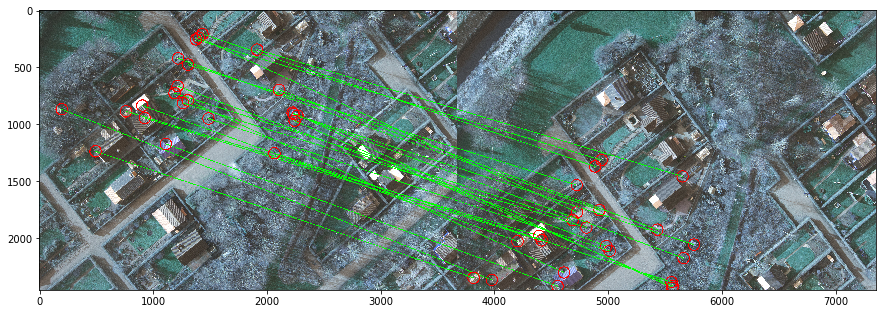

In [22]:
combined_img = stitch_imgs(img1_origin,img2_origin)
plt.figure(figsize=(15, 7))
draw_lines(combined_img, match_corners_A, match_corners_B)
#============== 2.Feature matching Done ==============#


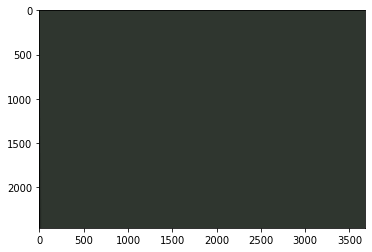

In [47]:
#============== 3.Image stitching ==============#
H_AB = computeH(match_corners_A,match_corners_B)
shape = (img1_origin.shape[1],img1_origin.shape[0])
img1_H = cv2.warpPerspective(img1_origin, H_AB, shape)
plt.imshow(img1_H)

In [30]:
lA = np.array(match_corners_A.copy())
# lA[:,[0,1]] = lA[:,[1,0]]

lB = np.array(match_corners_B.copy())
# lB[:,[0,1]] = lB[:,[1,0]]
h, mask = cv2.findHomography(lA, lB, cv2.RANSAC)


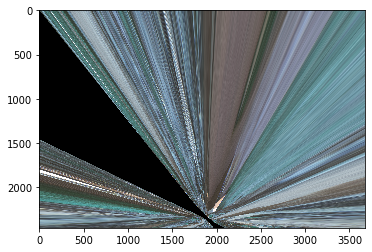

In [31]:
shape = (img1_origin.shape[1],img1_origin.shape[0])
img1_H = cv2.warpPerspective(img1_origin, h, shape)
plt.imshow(img1_H)